# Windowed attribute statistics

Let's say we'd like to compute the mean amplitude over a dataset, but inside a running window.

The easiest way to accomplish this is with `scipy.ndimage.generic_filter()`.

This wants a function, to which each sub-volume will be passed.

---

Let's load some data:

In [1]:
import numpy as np
import segyio

ds = np.DataSource('../data')  # <- Local target.

url = 'https://geocomp.s3.amazonaws.com/data/F3_8-bit_int.sgy'

with segyio.open(ds.open(url).name) as s:
    seismic = segyio.cube(s)
    
# Volume is int16. Turn it into floats.
seismic = (seismic / np.max(np.abs(seismic))).astype(float)
    
seismic.shape

(225, 300, 463)

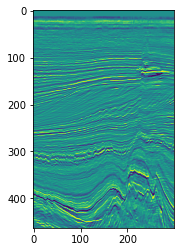

In [16]:
import matplotlib.pyplot as plt

plt.imshow(seismic[50].T)

Define the callback function:

In [11]:
def rms(data):
    """
    Root mean square.
    
    Example
    >>> rms([3, 4, 5])
    4.08248290463863
    """
    data = np.asanyarray(data)
    return np.sqrt(np.sum(data**2) / data.size)

Check that it works.

In [13]:
import doctest

doctest.testmod()

TestResults(failed=0, attempted=1)

**`generic_filter`** wants the data, the function, and the **`size`** of the sub-volume to pass in to the callback function. This can be trace-by-trace (use **1** for the first two dimensions) or multi-trace (e.g. use 3). A larger template will be slower to compute of course.

In [15]:
from scipy.ndimage import generic_filter

seismic_rms = generic_filter(seismic, rms, size=(1, 1, 11))

In [18]:
seismic_rms.shape

(225, 300, 463)

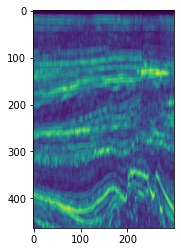

In [17]:
plt.imshow(seismic_rms[50].T)

## Other statistics

To get other statistics, we just need to change the function, or simply pass in a function from NumPy or wherever, eg:

```python
seismic_median = generic_filter(seismic, np.median, size=(3, 3, 11))
```

Gives a median filter computed over a kernel with shape 3 &times; 3 inlines by crosslines, and 11 time samples.

## Faster but fiddly

For the trace-by-trace case, we could speed this up by computing the RMS over various shifted versions of the seismic. This does not need more memory, because the shifted cubes are just views of the data. However, it does mean that the result will be shorter than the input, unless we somehow deal with the boundaries.

In [26]:
n = 11
vols = [seismic[:, :, ni:ni-n] for ni in range(n)]

In [27]:
data = np.asanyarray(vols)
seismic_rms = np.sqrt(np.sum(data**2, axis=0) / n)

In [28]:
seismic_rms.shape

(225, 300, 452)

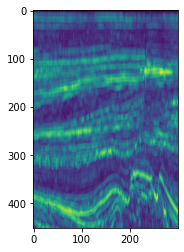

In [29]:
plt.imshow(seismic_rms[50].T)

Note that this volume has 5 samples 'missing' at the top, and another 5 at the bottom.

Also, this method won't work for multi-trace statistics.

---

&copy; 2022 Agile Scientific, licensed CC BY / Apache 2